In [85]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import importlib
import pytorch_gradient_boosting
importlib.reload(pytorch_gradient_boosting)
from pytorch_gradient_boosting import PyTorchGradientBoosting

In [86]:
data = pd.read_csv("../data/HR.csv")
data = data.rename(columns={"sales": "department"})
data = pd.get_dummies(data)
categorical = ['department_IT', 'department_RandD', 'department_accounting', 'department_hr', 
                'department_management', 'department_marketing', 'department_product_mng', 
                'department_sales', 'department_support', 'department_technical', 
                'salary_high', 'salary_low', 'salary_medium']
data[categorical] = data[categorical].astype(float)


y = data['left']
X = data.drop(columns=['left'])
numerical = X.columns.difference(categorical)
feature_names = X.columns.tolist()

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 9599
Validation set size: 2400
Test set size: 3000


In [87]:
# Initialize and train the model
model = PyTorchGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    reg_lambda=1.0,
    reg_alpha=0.1,
    class_weight='balanced'
)

# Train the model with early stopping
model.fit(
    X_train.values, 
    y_train.values,
    eval_set=(X_val.values, y_val.values),
    early_stopping_rounds=50,
    verbose=True
)


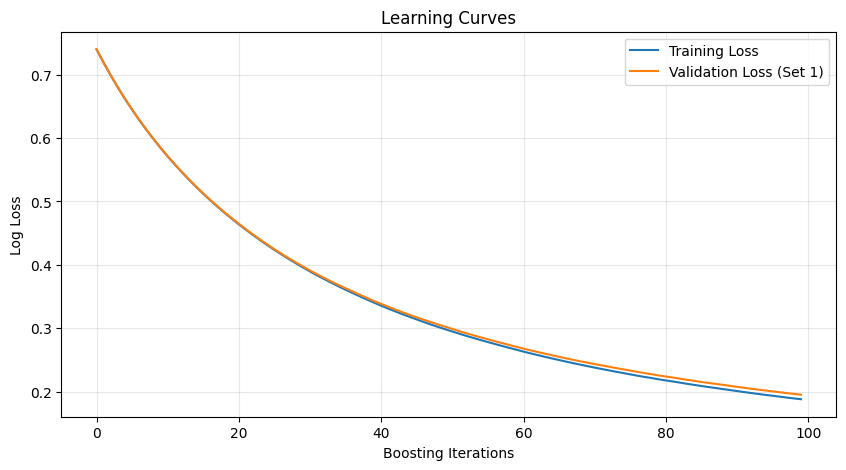

In [88]:
model.plot_learning_curve()

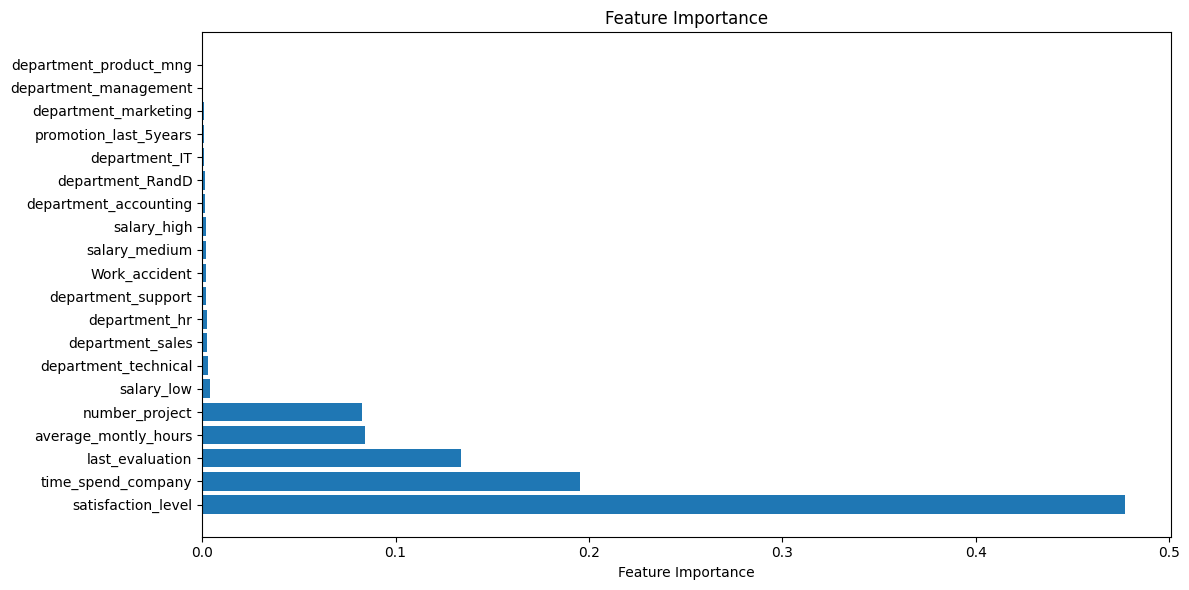

In [89]:
model.plot_feature_importance(feature_names)

In [90]:
# Make predictions on test set
y_pred_proba = model.predict_proba(X_test.values)
y_pred = model.predict(X_test.values)

# Convert PyTorch tensors to numpy for scikit-learn metrics
y_pred_proba_np = y_pred_proba.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Evaluate model
print("\nTest Set Evaluation:")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_np):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_np):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba_np):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_np):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_np):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_np):.4f}")


Test Set Evaluation:
AUC: 0.9904
Accuracy: 0.9757
Log Loss: 0.1994
Precision: 0.9495
Recall: 0.9482
F1 Score: 0.9488


In [91]:
best_threshold, best_score, threshold_metrics = model.calibrate_threshold(X_val.values, y_val.values, metric='f1')
print(f"\nBest threshold: {best_threshold:.4f}")
print(f"Best f1 score: {best_score:.4f}")
final_preds = (y_pred_proba_np >= best_threshold).astype(int)
print(f"Final accuracy with best threshold: {accuracy_score(y_test, final_preds):.4f}")


Best threshold: 0.5700
Best f1 score: 0.9573
Final accuracy with best threshold: 0.9750


c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to cont

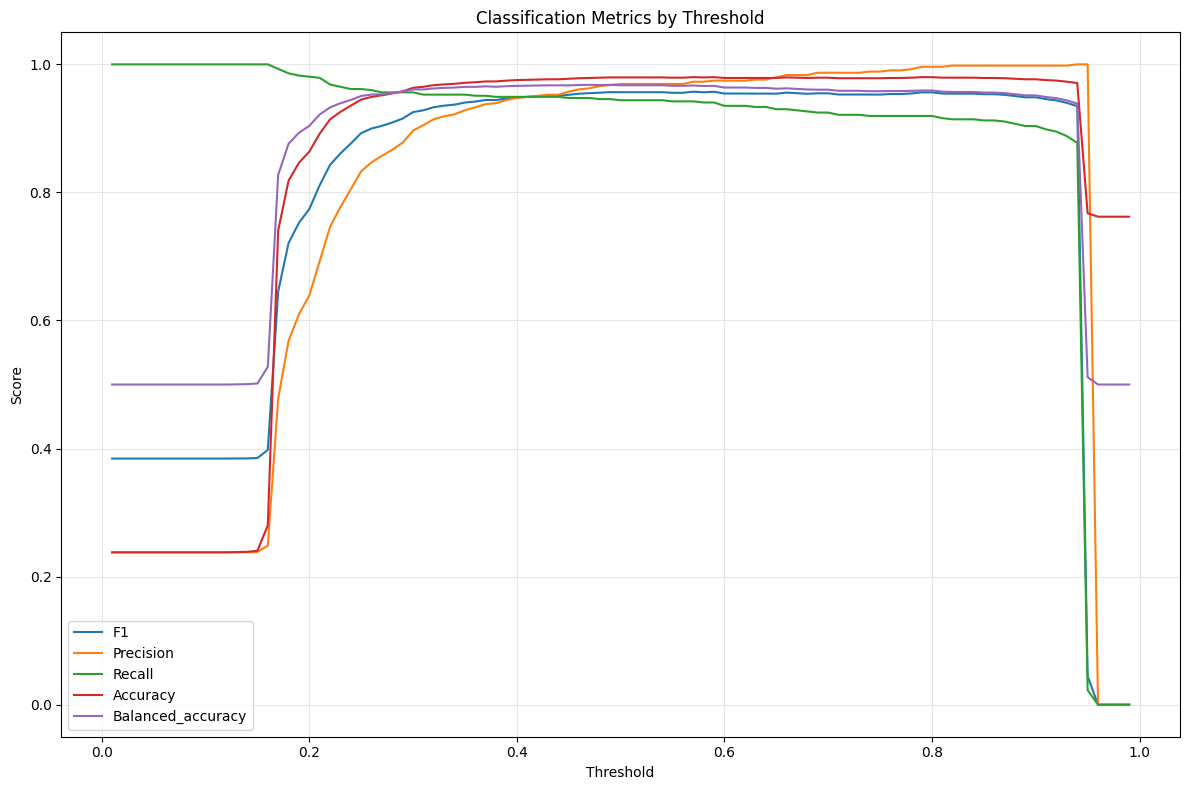

In [92]:
model.plot_threshold_metrics(threshold_metrics) 

In [93]:
model.save_model("xgboost.pth")


Model saved to xgboost.pth.pkl


Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 150/150 [04:20<00:00,  1.74s/it]

feature values [0.48 0.35 0.92 0.84 0.43 0.26 0.62 0.41 0.43 0.36 0.38 0.14 0.44 0.96
 0.64 0.8  0.91 0.72 0.98 0.59 0.37 0.51 0.74 0.83 0.72 0.86 0.6  0.37
 0.91 0.87 0.84 0.73 0.77 0.16 0.54 0.87 0.91 0.32 0.68 0.66 0.21 0.7
 0.88 0.2  0.11 0.53 0.09 0.37 0.74 0.8  0.91 0.55 0.6  0.51 0.8  0.82
 0.71 0.58 0.7  0.89 0.41 0.69 0.51 0.11 0.8  0.59 0.1  0.51 0.64 0.37
 0.44 0.68 0.16 0.65 0.82 0.11 0.44 0.55 0.48 1.   0.46 0.57 0.73 0.11
 0.1  0.77 0.86 0.74 0.88 0.45 0.39 0.38 0.34 0.48 0.75 0.78 0.83 0.6
 0.45 0.48 0.72 0.94 0.37 0.11 0.95 0.58 0.54 0.9  0.16 0.92 0.83 0.49
 0.8  0.49 0.8  0.66 0.44 0.78 0.45 0.4  0.83 0.15 0.86 0.56 0.23 0.77
 0.78 0.86 0.19 0.56 0.14 0.86 0.59 0.75 0.29 0.72 0.91 0.42 0.48 0.72
 0.91 0.53 0.23 0.85 0.68 0.85 0.77 0.19 0.83 0.44]
shap impact .values =
array([-0.03124801,  0.03821078, -0.06685942, -0.07376392,  0.02946079,
        0.02361221, -0.09806676,  0.19107992,  0.01124375,  0.20837983,
        0.21183589, -0.04388185,  0.00383938, -0.07933309, 

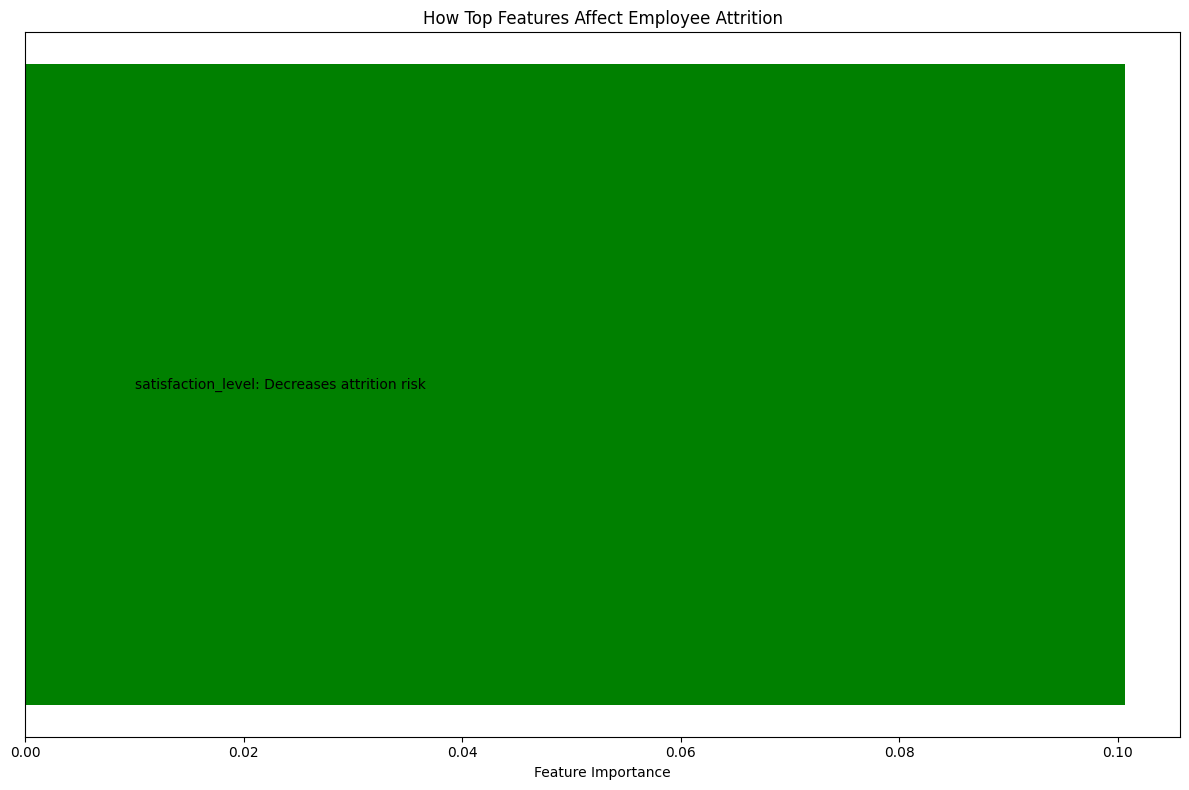

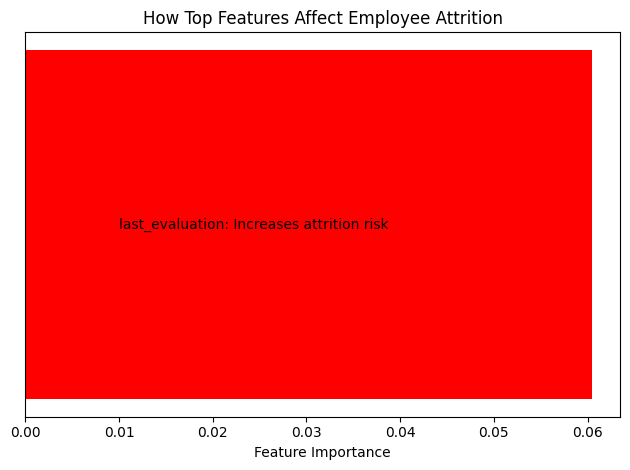

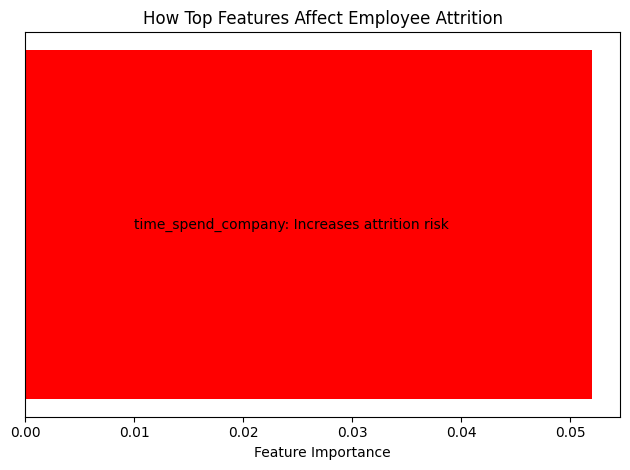

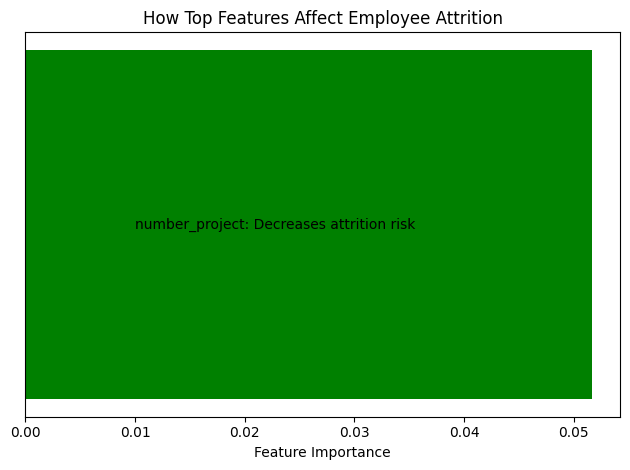

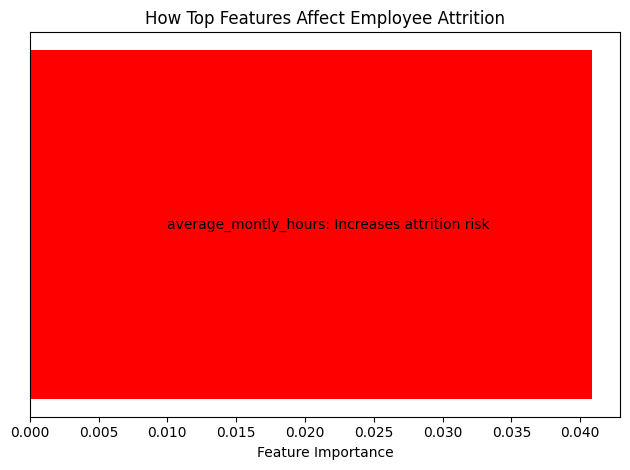

c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\xgboost_pytorch\pytorch_gradient_boosting.py:805: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


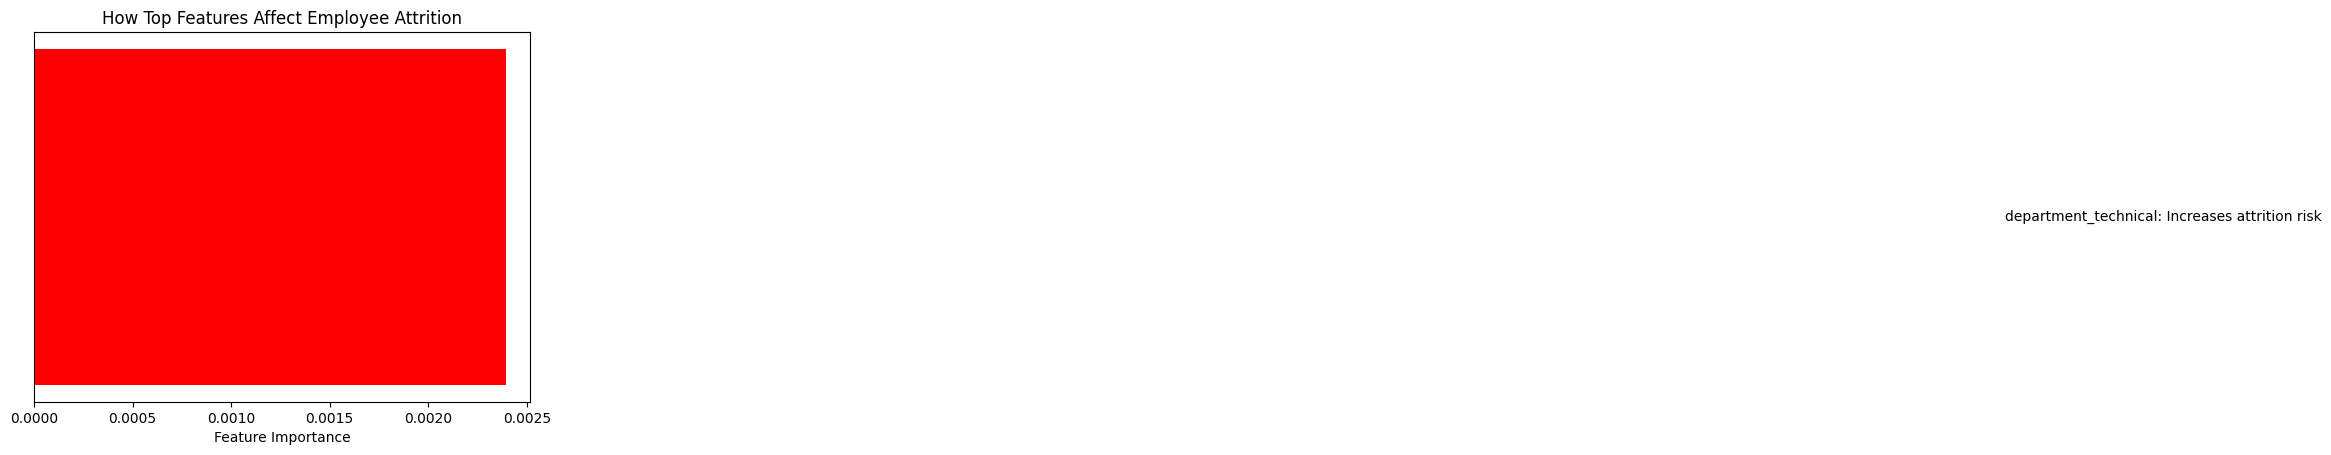

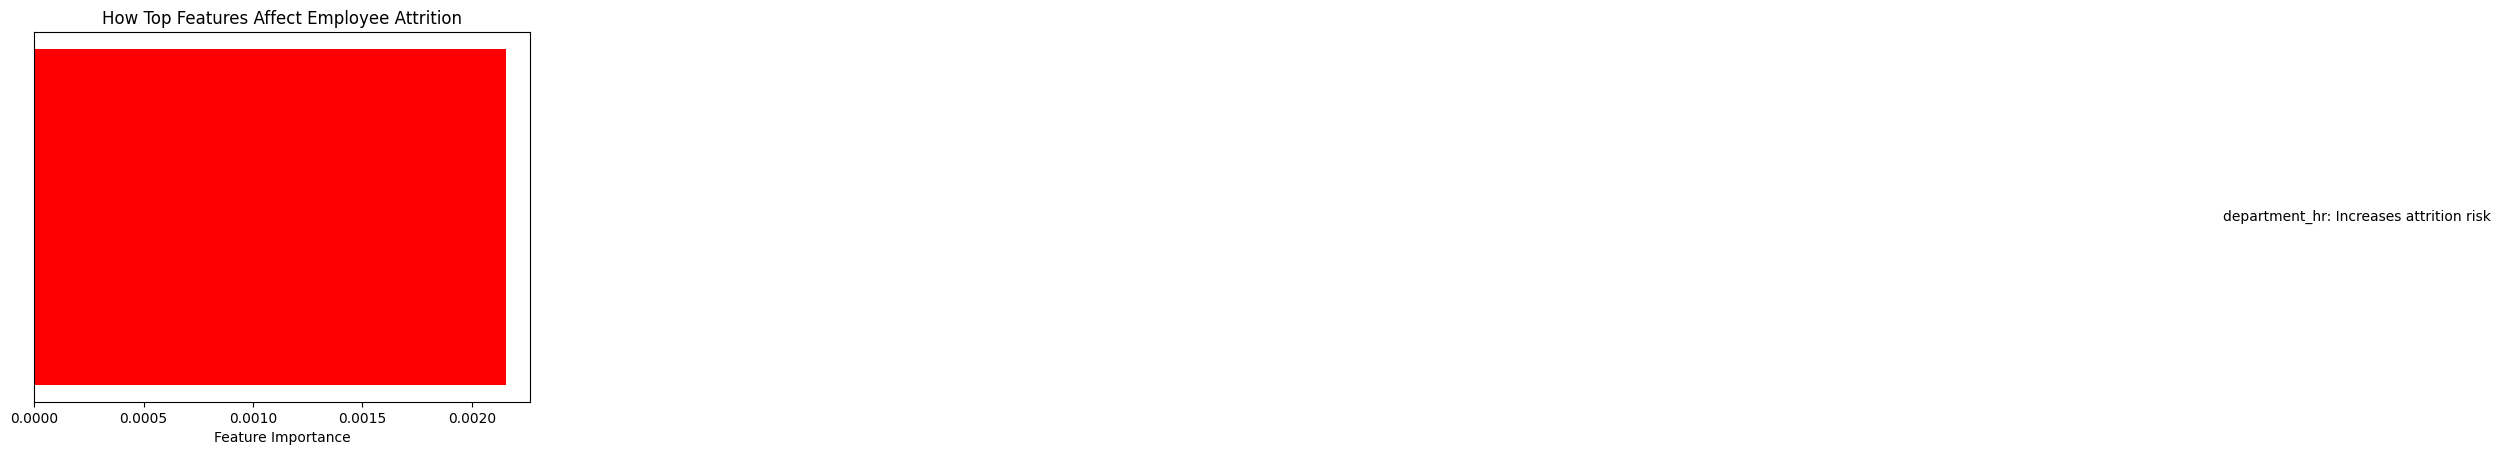

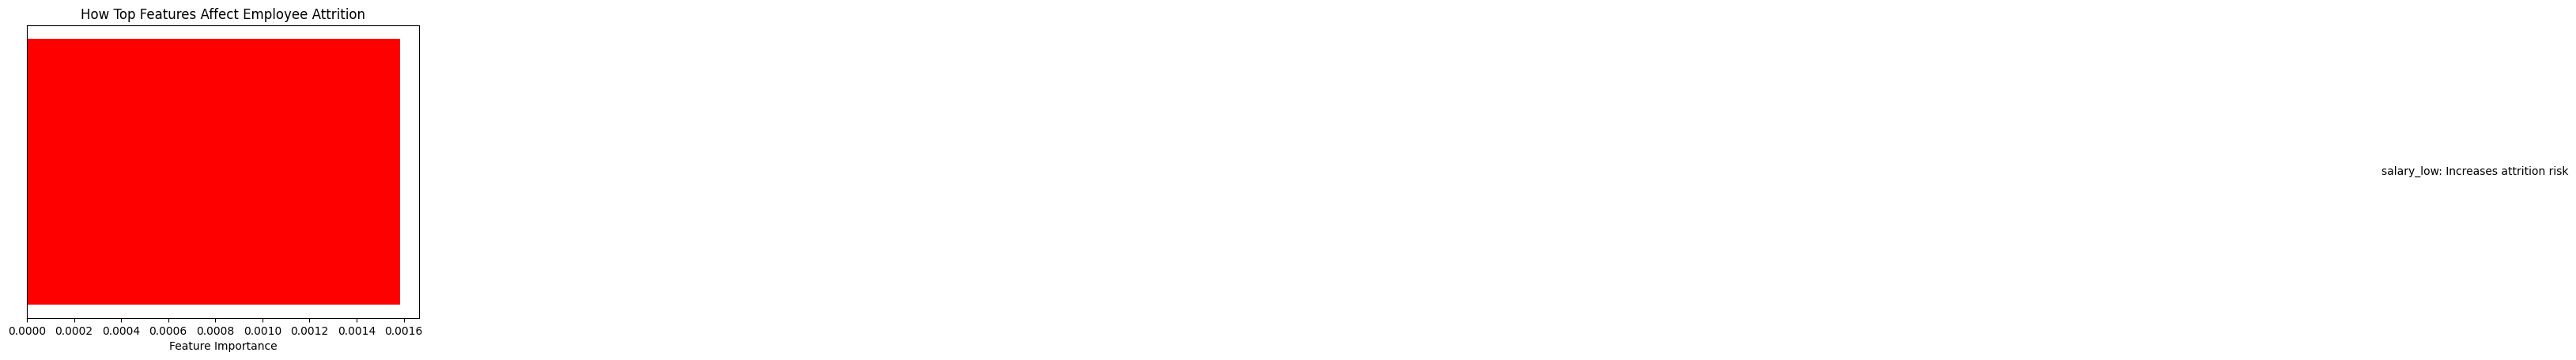

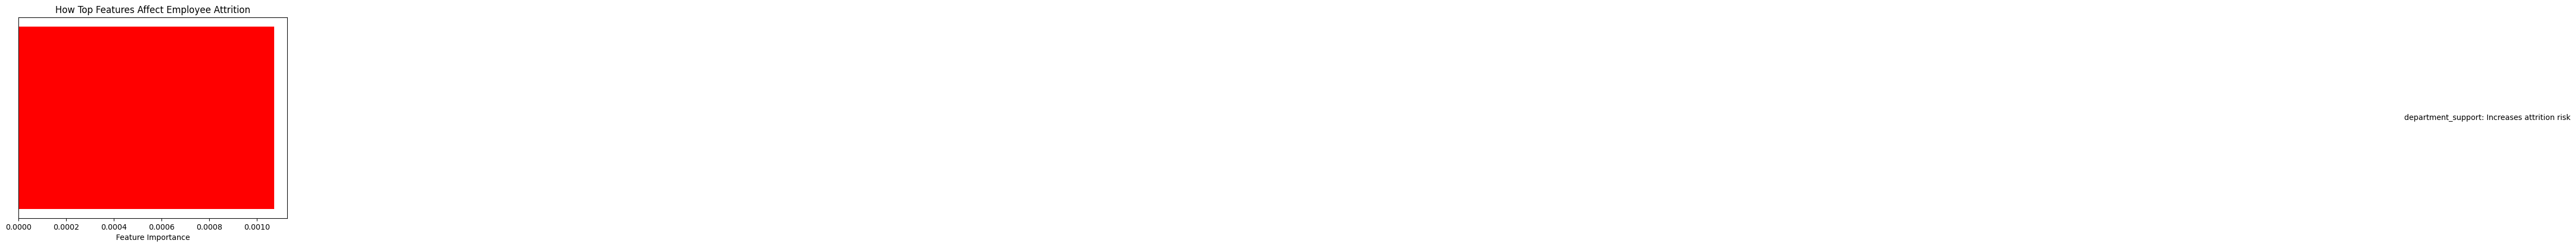

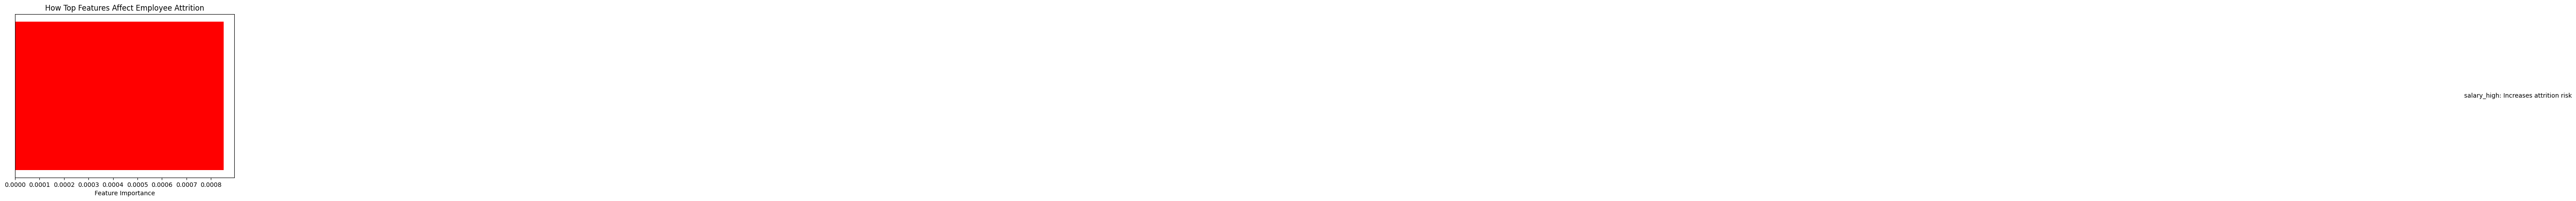

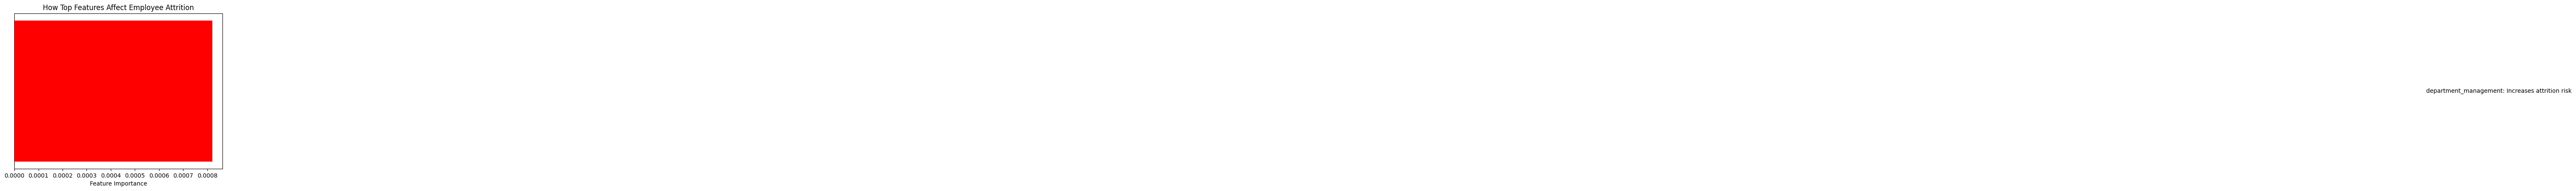

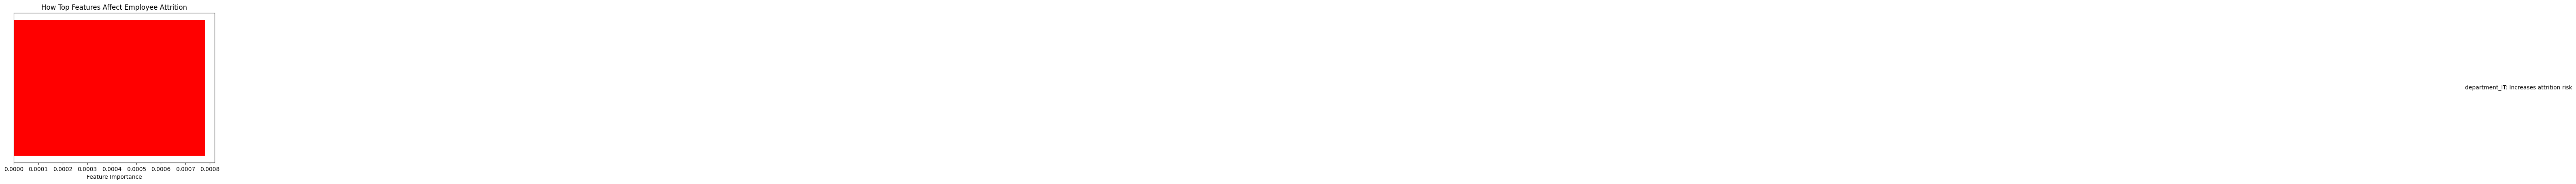

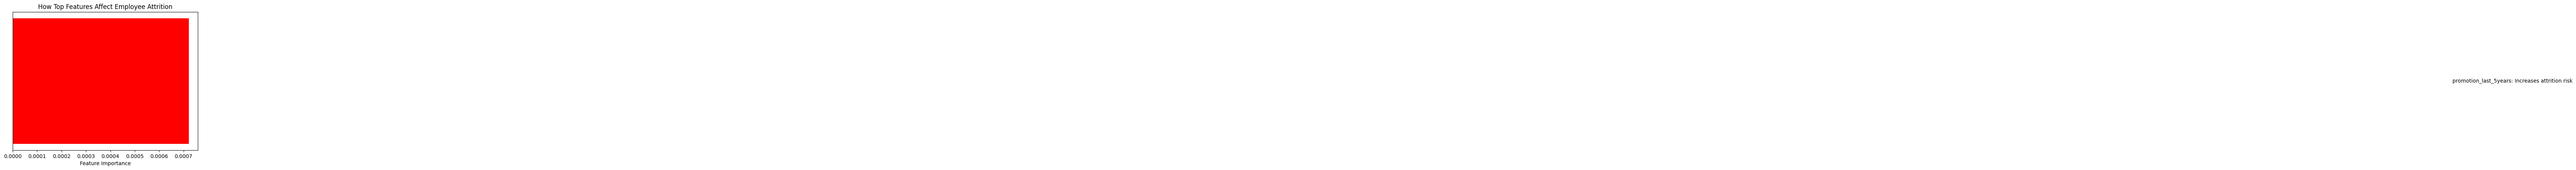

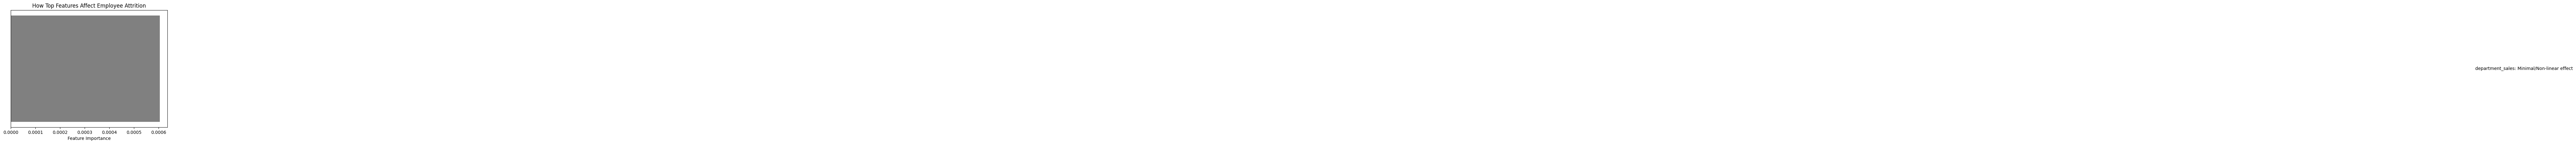

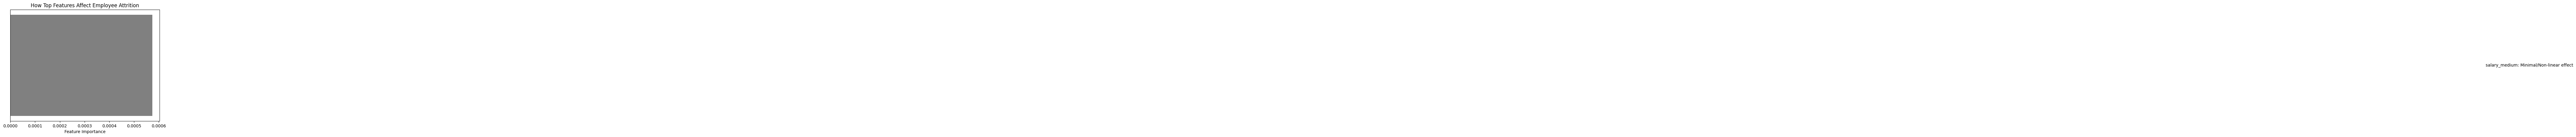

{'current_probability': 0.21099203824996948,
 'status': 'Already below threshold',
 'suggestions': []}

In [95]:
import torch
import shap

"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Choose a specific employee to explain (e.g., index 5 from test set)
employee_features = shap.sample(X_test, 150)
# Get explanation with SHAP
model.explain_prediction(
    torch.tensor(employee_features.values).to(device).numpy(), 
    feature_names=feature_names,
    plot=True  # This generates SHAP visualizations
)

model.suggest_improvements(
    torch.tensor(employee_features.values).to(device).numpy(),
    feature_names=feature_names,
    actionable_features=feature_names,
    threshold=0.5
)"""

In [82]:
X = X_test.sample(1)
X.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
233,0.42,0.56,2,134,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [84]:
model.make_suggestion(model, X)

tensor([0.9496])


['It seems that this employee is not satisfied with their job, as their satisfaction level is lower than expected. We recommend that HR and managers should talk to them to improve their situation.']